# Fetch the L2 FAC-Dual product

This is derived from data from Swarm Alpha and Charlie

Documentation on this product:

https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-2-product-definitions#FAC_TMS_2F

https://earth.esa.int/documents/10174/1514862/Swarm-L2-FAC-Dual-Product-Description

### Create the `SwarmRequest` object and check what variables are available

In [1]:
from viresclient import SwarmRequest
import datetime as dt
%matplotlib inline

request = SwarmRequest()
request.available_measurements("FAC")

['IRC',
 'IRC_Error',
 'FAC',
 'FAC_Error',
 'Flags',
 'Flags_F',
 'Flags_B',
 'Flags_q']

### Fetch the data for one day, along with quasidipole (QD) coordinates

In [2]:
request.set_collection("SW_OPER_FAC_TMS_2F")
request.set_products(
    measurements=["FAC", "FAC_Error", 
                  "Flags", "Flags_F", "Flags_B", "Flags_q"],
    auxiliaries=["QDLat", "QDLon"],
)
data = request.get_between(
    dt.datetime(2016,1,1),
    dt.datetime(2016,1,2)
)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (7.005MB)


In [3]:
df = data.as_dataframe()
df.head()

,Spacecraft,Latitude,Longitude,Radius,FAC,FAC_Error,Flags,Flags_F,Flags_B,Flags_q,QDLat,QDLon
2016-01-01 00:00:00.500,-,-72.499886,93.510969,6.833866e+06,0.056039,0.039585,0,22222224,2,404,-81.280106,104.292351
2016-01-01 00:00:01.500,-,-72.563053,93.539665,6.833867e+06,0.045774,0.039720,0,22222224,2,404,-81.314735,103.952469
2016-01-01 00:00:02.500,-,-72.626215,93.568595,6.833868e+06,0.036761,0.039856,0,22222224,2,404,-81.349075,103.609985
2016-01-01 00:00:03.500,-,-72.689371,93.597757,6.833869e+06,0.030307,0.039994,0,22222224,2,404,-81.383125,103.264832
2016-01-01 00:00:04.500,-,-72.752521,93.627157,6.833871e+06,0.025611,0.040132,0,22222224,2,404,-81.416862,102.917107


Depending on your application, you should probably do some filtering according to each of the flags. This can be done on the dataframe here, or beforehand on the server using [`request.set_range_filter()`](https://viresclient.readthedocs.io/en/v0.2.4/api.html#viresclient.SwarmRequest.set_range_filter). See https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-2-product-definitions#FAC_TMS_2F for more about the data

### Plot the time series

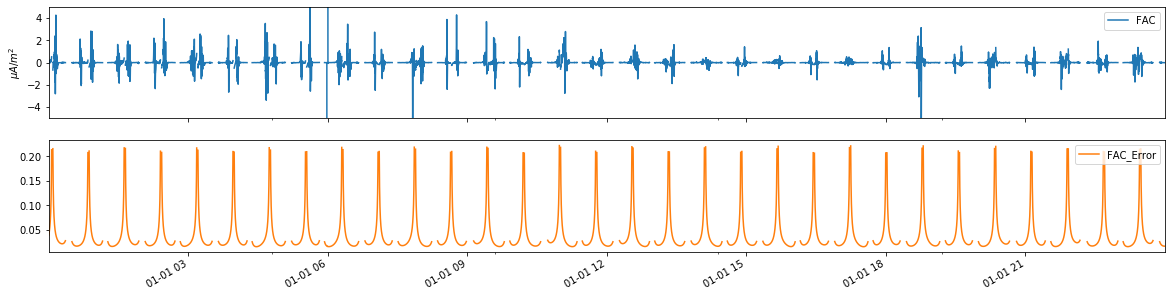

In [4]:
axes = df.plot(y=["FAC", "FAC_Error"], subplots=True, figsize=(20,5));
axes[0].set_ylim(-5, 5)
axes[0].set_ylabel("$\mu A / m^2$");

# "2D" plotting of a whole month

Fetch the data in two steps, for each hemisphere, at 10s sampling. Include `OrbitNumber` so that we can split according to orbit. Currently it is not possible to get `OrbitNumber` for the FAC-Dual product (since these are different numbers for Swarm A and C), so this is demonstrated for the single Swarm-Alpha FAC product.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [6]:
start_time = dt.datetime(2016,1,1)
end_time = start_time + dt.timedelta(days=30)

request = SwarmRequest()
request.set_collection("SW_OPER_FACCTMS_2F")
request.set_products(
    measurements=["FAC"],
    auxiliaries=["QDLat", "OrbitNumber", "QDOrbitDirection"],
    sampling_step="PT10S"
)
request.set_range_filter("QDLat", 50, 90)
dfNorth = request.get_between(start_time, end_time).as_dataframe()
request.clear_range_filter()
request.set_range_filter("QDLat",-90,-50)
dfSouth = request.get_between(start_time, end_time).as_dataframe()

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:12, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (3.063MB)
[1/1] Processing:  100%|██████████|  [ Elapsed: 00:10, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (3.19MB)


##### NB: since writing the following code, it should now be possible to do it in a simpler way, using the new `QDOrbitDirection` flag  (see next)

current issues: xticklabels not appearing, and unnecessary duplication of colorbar

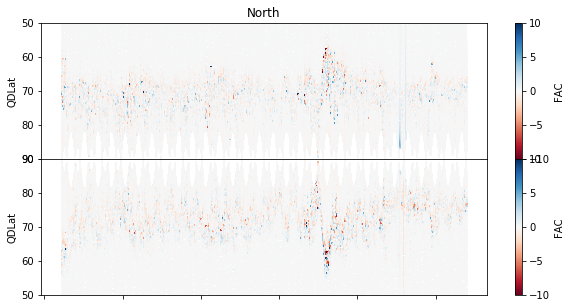

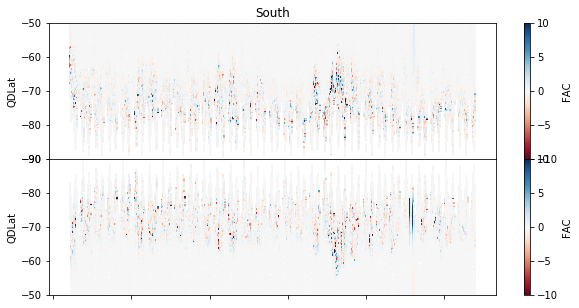

In [7]:
def split_ascdesc(df):
    # Split into new dataframes asc & desc, for passes going towards pole and away from pole resp.
    # Add columns that say whether each entry is part of an asc or desc (partofpass),
    #  and the times of approximate pole-crossing for the containing pass (OrbitTime)
    dfnew = pd.DataFrame()
    for orbno, each_pass in df.groupby("OrbitNumber"):
        midpt = int(len(each_pass)/2)
        each_pass_asc = each_pass.iloc[:midpt].copy()
        each_pass_asc = each_pass_asc.assign(partofpass="ascending")
        each_pass_asc = each_pass_asc.assign(OrbitTime=each_pass.index[midpt].to_pydatetime())
        each_pass_desc = each_pass.iloc[midpt:].copy()
        each_pass_desc = each_pass_desc.assign(partofpass="descending")
        each_pass_desc = each_pass_desc.assign(OrbitTime=each_pass.index[midpt].to_pydatetime())
        dfnew = dfnew.append(each_pass_asc)
        dfnew = dfnew.append(each_pass_desc)
    (_,asc), (_,desc) = list(dfnew.groupby("partofpass"))
    return asc, desc

# Split the Northern and Southern dataframes each into
# ascending (towards the pole) and
# descending (away from the pole) dataframes
N_asc, N_desc = split_ascdesc(dfNorth)
S_asc, S_desc = split_ascdesc(dfSouth)


# Plot each of the 4 dataframes onto their own matplotlib axes

cmap = cm.RdBu
norm = Normalize(vmin=-10,vmax=10)

# NB bug in pandas scatter not supporting datetime: https://github.com/pandas-dev/pandas/issues/8113
# Workaround:
# https://stackoverflow.com/a/44572082
def scatterplot(df, ax):
    df['OrbitTime_int'] = df['OrbitTime'].astype(np.int64)
    df.plot(x='OrbitTime_int', y='QDLat', c='FAC', kind='scatter', s=1, marker=',', ax=ax, cmap=cmap, norm=norm)
    ax.set_xticklabels([dt.datetime.fromtimestamp(ts / 1e9).strftime('%d/%m/%Y') for ts in ax.get_xticks()])

fig1, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,5), sharex=True)
scatterplot(N_desc, ax1)
scatterplot(N_asc, ax2)
ax1.set_ylim((90,50))
ax2.set_ylim((50,90))
fig1.subplots_adjust(hspace=0)
ax1.set_title("North")

fig2, (ax3, ax4) = plt.subplots(nrows=2, figsize=(10,5), sharex=True)
scatterplot(S_desc, ax3)
scatterplot(S_asc, ax4)
ax3.set_ylim((-90,-50))
ax4.set_ylim((-50,-90))
fig2.subplots_adjust(hspace=0)
ax3.set_title("South");

### Shorter version of the above

Splitting according to whether the orbit has passed the QD pole or not. Then using OrbitNumber as the x axis for the scatterplot. TODO: Use a mapping between OrbitNumber and an approximate "OrbitTime" to set the xticklabels.

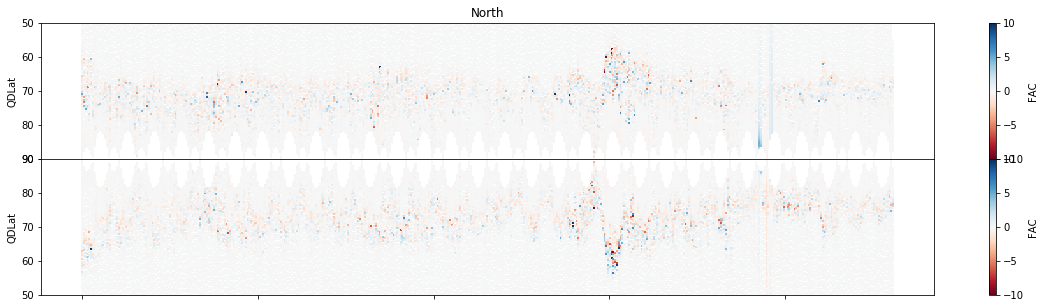

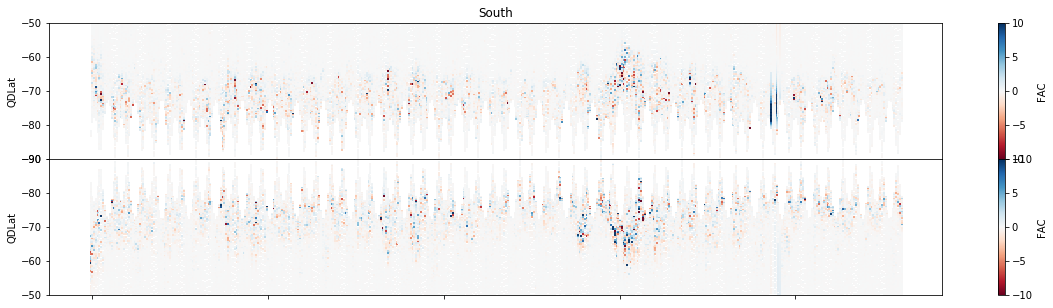

In [8]:
df_N_asc = dfNorth[dfNorth["QDOrbitDirection"] == 1]
df_N_desc = dfNorth[dfNorth["QDOrbitDirection"] == -1]
df_S_asc = dfSouth[dfSouth["QDOrbitDirection"] == 1]
df_S_desc = dfSouth[dfSouth["QDOrbitDirection"] == -1]

fig1, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,5), sharex=True)
scatter_kwargs = {
    'x': 'OrbitNumber', 'y': 'QDLat', 'c': 'FAC',
    's': 1, 'marker': ',', 'cmap': cm.RdBu, 'norm': Normalize(vmin=-10,vmax=10)
}
df_N_desc.plot.scatter(ax=ax1, **scatter_kwargs)
df_N_asc.plot.scatter(ax=ax2, **scatter_kwargs)
ax1.set_ylim((90,50))
ax2.set_ylim((50,90))
fig1.subplots_adjust(hspace=0)
ax1.set_title("North")

fig2, (ax3, ax4) = plt.subplots(nrows=2, figsize=(20,5), sharex=True)
df_S_desc.plot.scatter(ax=ax3, **scatter_kwargs)
df_S_asc.plot.scatter(ax=ax4, **scatter_kwargs)
ax3.set_ylim((-90,-50))
ax4.set_ylim((-50,-90))
fig2.subplots_adjust(hspace=0)
ax3.set_title("South");